In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install segmentation-models-pytorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00


In [3]:
import segmentation_models_pytorch as smp

In [4]:
import cv2
from matplotlib import pyplot as plt
# data storing library
import numpy as np
import pandas as pd
# torch libraries
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.transforms as transforms
# others
import os
import pdb
import time
import warnings
import random
from tqdm import tqdm_notebook as tqdm
import concurrent.futures
from PIL import Image

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
from PIL import Image

In [6]:
class customDataset(Dataset):

  def __init__(self,imagePaths,maskPaths,transform,preprocessing=None):
    #store the image and mask filepaths, and augmentation
    #transform
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transform
    self.preprocessing = preprocessing

  def __len__(self):
    return 1286
    # return 48


  def __getitem__(self, idx):
    # grab the image path from the current index
    idx += 1
    imagePath = os.path.join(self.imagePaths,f"{idx}.png")
    maskPath = os.path.join(self.maskPaths,f"{idx}.png")

    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode

    # image = cv2.imread(imagePath)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(image.shape)
    # mask = cv2.imread(maskPath, 0)

    image = Image.open(imagePath)
    mask = Image.open(maskPath).convert("L").convert("1")


    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.transforms(mask)

    if self.preprocessing:
      sample = self.preprocessing(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']



    # return a tuple of the image and its mask
    return (image, mask)



In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
path = '/content/gdrive/MyDrive/sem_project/WCEBleedGen'
imagePath = os.path.join(path,'bleed/img')
maskPath = os.path.join(path,'bleed/mask')

In [9]:
dataset = customDataset(imagePath,maskPath,transform)

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])
1286


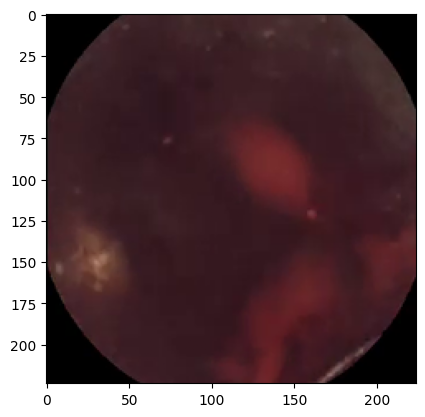

In [10]:
image,mask = dataset[11]
plt.imshow(image.permute(1,2,0))
# plt.imshow(mask.permute(1,2,0))
# transforms.functional.to_pil_image(image).show()
print(image.shape)
print(mask.shape)
print(len(dataset))

In [11]:
batch_size = 8
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - (train_len)


In [12]:
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_len, val_len])

In [13]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size = batch_size)

In [14]:
for i,mask in val_ds:
  print(i.shape)
  ima=transforms.functional.to_pil_image(mask)
  print(ima.size)
  ima.save("/content/gdrive/MyDrive/valid/v1.png")
  break
  # ima.save("/content/gdrive/MyDrive/valid")



torch.Size([3, 224, 224])
(224, 224)


In [15]:
for inputs, masks in train_dl:
  print(inputs.shape,masks.shape)
  break

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


In [16]:
if not torch.cuda.is_available():
  device = 'cpu'
else:
  device = 'cuda'
print(device)

cuda


In [17]:
from segmentation_models_pytorch import utils

In [18]:
Encoder = "resnet18"
Encoder_weights = "imagenet"
Activation = 'sigmoid'
# model = smp.MAnet(encoder_name=Encoder,encoder_weights=Encoder_weights,in_channels=3,classes=1,activation=Activation)

In [19]:
model = smp.Unet(encoder_name=Encoder,encoder_weights=Encoder_weights,in_channels=3,classes=1,activation=Activation)
model.to(device)

loss = utils.losses.DiceLoss()

metrics = [
    utils.metrics.Accuracy(),
    utils.metrics.Precision(),
    utils.metrics.Recall(),
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.8MB/s]


In [20]:
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

In [ ]:
max_iou_score = 0
max_accuracy_score = 0
max_precision_score = 0
max_recall_score = 0
l = []
for i in range(0, 50):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dl)
    valid_logs = valid_epoch.run(valid_dl)
    l.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_iou_score < valid_logs['iou_score']:
      max_iou_score = valid_logs['iou_score']
        # torch.save(model, './best_model.pth')
        # print('Model saved!')
    if max_accuracy_score < valid_logs['accuracy']:
      max_accuracy_score = valid_logs['accuracy']
    if max_precision_score < valid_logs['precision']:
      max_precision_score = valid_logs['precision']

    if max_recall_score < valid_logs['recall']:
      max_recall_score = valid_logs['recall']



    if i == 15:
        optimizer.param_groups[0]['lr'] = 5e-5
        print('Decrease decoder learning rate to 5e-5!')
    elif i == 30:
      optimizer.param_groups[0]['lr'] = 7e-6
      print('Decrease decoder learning rate to 5e-5!')
    elif i == 40:
      optimizer.param_groups[0]['lr'] = 5e-7
      print('Decrease decoder learning rate to 5e-5!')


    print(f"[-] metrics for epoch {i} on val: max_iou {max_iou_score} max_accuracy: {max_accuracy_score} max_precision: {max_precision_score} max_recall: {max_recall_score}")




In [22]:
torch.save(model, f'/content/gdrive/MyDrive/best_model_{Encoder}1.pth')
print('Model saved!')

Model saved!


In [21]:
best_model = torch.load(f'/content/gdrive/MyDrive/best_model_{Encoder}.pth')

In [23]:
pip install xlwt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 2.5 MB/s eta 0:00:00


In [24]:
import xlwt
from xlwt import Workbook

In [28]:
wb = Workbook()
sheet1 = wb.add_sheet('Sheet 1')
sheet1.write(0, 0, 'Image Name')
sheet1.write(0,1,'Predicted Class Label')
path = "/content/gdrive/MyDrive/Btechproject/test/Test1"
bleed = 0
nonbleed = 0
cnt = 1
for i in sorted(os.listdir(path)):
  path_to_image = os.path.join(path, i)
  img = Image.open(path_to_image)
  img = transform(img)
  # plt.imshow(img.permute(1,2,0))
  img=img.to(device)
  img = torch.unsqueeze(img, dim=0)
  pr_mask=best_model.predict(img).squeeze(dim=0)
  # print(torch.unique(pr_mask,sorted=True))
  # print(pr_mask.shape)
  pr_mask = transforms.functional.to_pil_image(torch.round(pr_mask.cpu()))

  if len(np.unique(pr_mask)) == 1:
     nonbleed += 1
     sheet1.write(cnt, 0, i)
     sheet1.write(cnt, 1, 'Non-Bleeding')
  else:
    # print(np.unique(pr_mask))
    bleed += 1
    sheet1.write(cnt, 0, i)
    sheet1.write(cnt, 1, 'Bleeding')

  cnt += 1

wb.save('./ans.xls')
print(bleed,nonbleed)
  # if not os.path.isdir(f"/content/gdrive/MyDrive/finalval/{Encoder}"):
  #   os.mkdir(f"/content/gdrive/MyDrive/finalval/{Encoder}")
  # pr_mask.save(os.path.join(f"/content/gdrive/MyDrive/finalval/{Encoder}",i))

29 20


In [ ]:
path = '/content/gdrive/My Drive/Btechproject'
imagePath = os.path.join(path,'test/Test1')
maskPath = os.path.join(path,'test/mask1')

dataset_test = customDataset(imagePath,maskPath,transform)

test_dl = DataLoader(dataset_test)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=device,
)
logs = test_epoch.run(test_dl)

In [ ]:
path = "/content/gdrive/MyDrive/Btechproject/test/Test1"
for i in os.listdir(path):
  path_to_image = os.path.join(path, i)
  img = Image.open(path_to_image)
  img = transform(img)
  # plt.imshow(img.permute(1,2,0))
  img=img.to(device)
  img = torch.unsqueeze(img, dim=0)
  pr_mask=best_model.predict(img).squeeze(dim=0)
  # print(torch.unique(pr_mask,sorted=True))
  # print(pr_mask.shape)
  pr_mask = transforms.functional.to_pil_image(torch.round(pr_mask.cpu()))
  if not os.path.isdir(f"/content/gdrive/MyDrive/finalval/{Encoder}"):
    os.mkdir(f"/content/gdrive/MyDrive/finalval/{Encoder}")
  pr_mask.save(os.path.join(f"/content/gdrive/MyDrive/finalval/{Encoder}",i))


In [ ]:
!pip install shap --quiet

In [ ]:
def predict(img):
  print(type(img), img.shape)
  img = torch.tensor(img[0,:,:,:])
  img = img.cuda()
  img = torch.unsqueeze(img, 0)
  pr_mask = best_model(img)
  pr_mask = pr_mask.squeeze()
  return pr_mask

In [ ]:
import shap
import matplotlib.pyplot as plt

path = "/content/gdrive/MyDrive/Btechproject/test/Test1"
i="0.png"
path_to_image = os.path.join(path, i)
img = Image.open(path_to_image)
img = transform(img)

masker_blur = shap.maskers.Image("inpaint_telea", (3, 224, 224))
image, msk = val_ds[4]
print(img.dtype, msk.shape, msk.dtype)
output = masker_blur(mask=val_ds[4][1].to(torch.uint8), x=val_ds[4][0])
print(output[0].shape)
plt.imshow(output[0].reshape(224, 224, 3))

# explainer = shap.Explainer(predict, masker=masker_blur)
# shap_values = explainer(val_ds[4], max_evals=100, outputs=shap.Explanation.argsort.flip[:4])

torch.float32 torch.Size([1, 224, 224]) torch.float32


RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mark_boundaries(img.cpu().numpy().transpose((1, 2, 0)), mask))
plt.axis('off')
plt.show()